# **Supervised Text Classification for Marketing Analytics Final Project**

## _Development of a Deep Learning Model for Identifying Health and Wellness News_




### **1. Introduction**

In the current landscape of digital advertising, contextual advertising plays a fundamental role by allowing advertisers to position their ads on web pages relevant to their target audience. Chrishare, a media buying company, has received a request from its client, Theragun, to develop a deep learning model capable of automatically identifying news related to health and wellness. This project aims to create a classifier using ktrain, an interface for TensorFlow, Keras, and Huggingface Transformers, to optimize ad targeting.



### **2. Dataset**

The dataset used in this study was obtained from HuffPost and consists of approximately 200,000 news headlines from 2012 to 2018, categorized into different topics. The most relevant categories for this study include:

* WELLNESS (17,827 headlines)

* HEALTHY LIVING (6,694 headlines)

The goal is to train a model that correctly classifies headlines belonging to these categories, thereby enabling the effective segmentation of content for Theragun’s ad placements.

In [22]:
# LIBRARIES
import time
import os

# Set TensorFlow environment variables to use legacy Keras API
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"


# Start time
start_time = time.time()

# Try importing ktrain; install dependencies if missing
try:
    import ktrain
    from ktrain import text
except:
    # Install necessary libraries if not already installed
    !pip install tf_keras
    !pip install ktrain --upgrade
    !pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

# Set CUDA settings for GPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Import required libraries
import gdown
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import ktrain
from ktrain import text
import numpy as np
import random
import warnings
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


# Ignore specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

# General Configuration
class Config:
    MAXLEN = 500
    SEED = 42
    CATEGORIES = ['WELLNESS', 'HEALTHY LIVING']
    MODEL_NAME = 'distilbert-base-uncased'
    EPOCHS = 4
    BATCH_SIZE = 6

# Set seed for reproducibility
tf.keras.utils.set_random_seed(Config.SEED)
np.random.seed(Config.SEED)
random.seed(Config.SEED)

# Google Drive file ID
file_id = "1snUBKqjMfN5E695jWyaCc_yuEh5cQ3rY"

# Construct direct download URL
url = f"https://drive.google.com/uc?id={file_id}"

# Temporary local filename
output = "data.json"

# Download the file
gdown.download(url, output, quiet=False)

# Open and load JSON data
with open(output, "r", encoding="utf-8") as f:
    json_data = json.load(f)

# Convert JSON data to DataFrame
if isinstance(json_data, list):  # If JSON contains a list of records
    data = pd.DataFrame(json_data)
elif isinstance(json_data, dict):  # If JSON contains a dictionary
    data = pd.DataFrame.from_dict(json_data, orient="index")
else:
    raise ValueError("Unsupported JSON format for DataFrame conversion.")

# Transpose data to fix structure if needed
data = data.T

# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Filter data based on selected categories
categories = Config.CATEGORIES
data = data[data['category'].isin(categories)]

# Drop unnecessary columns
data = data.drop(columns=['link'])

# Reset DataFrame index
data.reset_index(drop=True, inplace=True)

# Clear output for cleaner display
clear_output(wait=True)


In [24]:
# Display first few rows of the dataset
data.head()

,category,headline,authors,short_description,date
0,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...","When you feel like this, it’s important to kno...",2018-01-16
1,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",I can vividly remember the first time I felt f...,2018-01-12
2,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,Because it's only becoming more of a struggle.,2018-01-12
3,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,"""The only Whole30 I want to participate in is ...",2018-01-10
4,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...","Essentially, your hands are kept warm thanks t...",2018-01-10


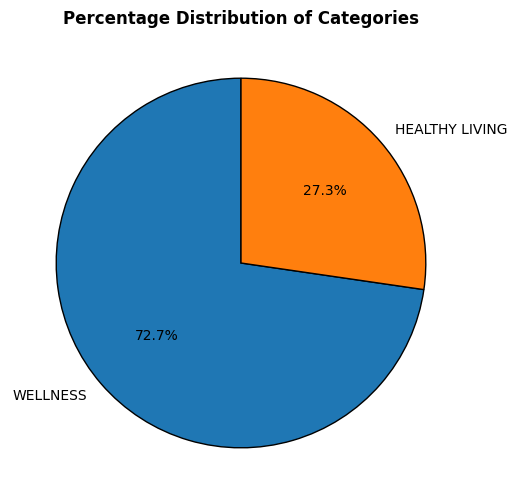

In [4]:
# Calculate the percentage of each category
category_counts = data["category"].value_counts()
category_percent = (category_counts / category_counts.sum()) * 100

# Create a pie chart
plt.figure(figsize=(12, 6))
category_percent.plot(kind="pie", autopct="%.1f%%", startangle=90, wedgeprops={'edgecolor': 'black'})

# Set title and formatting
plt.title("Percentage Distribution of Categories", fontweight="bold")
plt.ylabel("")  # Remove y-axis label for better visualization

# Display the chart
plt.show()

In [5]:
data["category"].value_counts()

category
WELLNESS          17827
HEALTHY LIVING     6694
Name: count, dtype: int64

In [6]:
# Count occurrences of each category
category_counts = data["category"].value_counts()

# Compute the imbalance ratio between the most and least frequent categories
imbalance_ratio = category_counts.max() / category_counts.min()

# Display the imbalance ratio
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")

Imbalance ratio (max/min): 2.66


An imbalance ratio of **2.66** means that the most frequent category has **2.66 times** more instances than the least frequent one. This level of imbalance is not extreme, but it may still be relevant depending on the context of your problem.  

Since we are dealing with a **supervised classification** task, addressing this imbalance might be necessary to prevent the model from favoring the majority class.

## **3. Metodology**



### **3.1 Data Processing**



In [7]:
data['text'] = data['headline'] + ' ' + data['short_description']
data = data[['text', 'category']]


In [8]:
data.head()

,text,category
0,To The People Who Say ‘I’m Tired’ When Someone...,HEALTHY LIVING
1,Eating Shake Shack Made Me Feel Healthier Than...,HEALTHY LIVING
2,How To Stay Updated On The News Without Losing...,HEALTHY LIVING
3,27 Perfect Tweets About Whole30 That Will Make...,HEALTHY LIVING
4,The Real Reason Your Hands Are Always Cold Ess...,HEALTHY LIVING


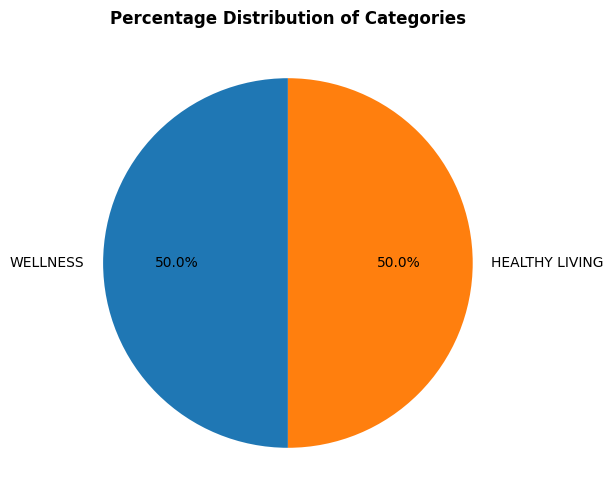

In [9]:
# Separate "text" and Labels
text_data = data['text']
labels = data['category']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(text_data, labels, test_size=0.20, random_state=Config.SEED)

# Create a DataFrame with training data
df = pd.DataFrame({'text': X_train, 'category': y_train})

# Separate classes
df_majority = df[df['category'] == Config.CATEGORIES[0]]
df_minority = df[df['category'] == Config.CATEGORIES[1]]

# Upsample the minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,  # Sample with replacement
                                 n_samples=len(df_majority),  # Match majority class size
                                 random_state=42)  # Ensure reproducibility

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Compute class distribution
category_counts = df_upsampled["category"].value_counts()
category_percent = (category_counts / category_counts.sum()) * 100

# Plot class distribution
plt.figure(figsize=(12, 6))
category_percent.plot(kind="pie", autopct='%1.1f%%', startangle=90)
plt.title("Percentage Distribution of Categories",fontweight="bold")
plt.ylabel("")
plt.show()


Now, the dataset is balanced, meaning that the categories `WELLNESS` and `HEALTHY LIVING` have the same number of examples in the training set. This was achieved using a technique called **upsampling**, where the minority class (`WELLNESS`) was increased by randomly replicating its examples until both classes had an equal number of records. This balancing process is crucial to prevent the machine learning model from learning biased patterns that favor the originally more represented class. As a result, the model will perform more fairly and reliably when classifying new texts.

### **3.2 Machine Learning Model**

In [10]:
# Processing text from DataFrame
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(
    train_df=df_upsampled,  # Input DataFrame
    text_column='text',  # Column containing text data
    label_columns='category',  # Column containing labels
    maxlen=Config.MAXLEN,  # Maximum sequence length
    preprocess_mode='bert',  # Preprocessing mode using BERT
)

# Creating a BERT text classifier model
model = text.text_classifier(
    name='bert',  # Model type
    train_data=(x_train, y_train),  # Training data
    preproc=preproc,  # Preprocessing object
)

# Initializing the learner
learner = ktrain.get_learner(
    model=model,  # The classifier model
    train_data=(x_train, y_train),  # Training dataset
    val_data=(x_test, y_test),  # Validation dataset
    batch_size=Config.BATCH_SIZE,  # Batch size for training
)

# Clear previous outputs
clear_output()

# Print confirmation message
print('Model Loaded!')

Model Loaded!


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
4289/4289 [==============================] - 8871s 2s/step - loss: 3.5535 - accuracy: 0.5663


done.
Visually inspect loss plot and select learning rate associated with falling loss


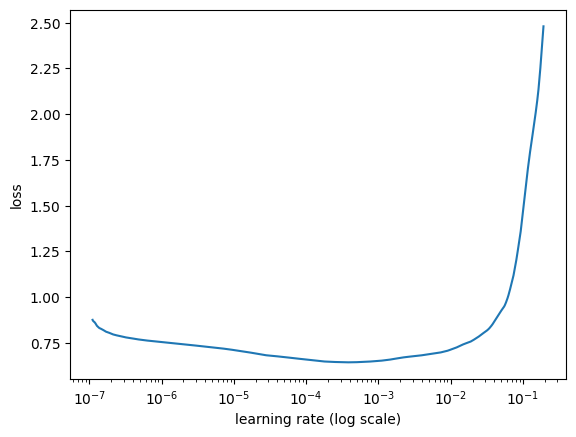

In [11]:
# Perform a learning rate range test
learner.lr_find(show_plot=True)

In this approach, we observed that the model's accuracy is very low, around **55% (0.55)**. Even with some adjustments and optimizations, it would be difficult to exceed **70% (0.7)**, resulting in a model with unsatisfactory performance for the text classification task.

Given this scenario, a more effective alternative is to use **Transformer models**, which are advanced neural networks capable of better capturing word patterns and context. These models are widely used in **Natural Language Processing (NLP)** tasks due to their deep learning capabilities.

To begin, we have chosen the **"distilbert-base-uncased"** model, an optimized version of **BERT (Bidirectional Encoder Representations from Transformers)**, which maintains a good balance between performance and computational efficiency. We will use this model to train our dataset and assess whether we can achieve a significant improvement in classification accuracy.

### **3.2.1 Using Transformers Model**

#### **3.2.1.1 Load Data**

In [12]:
# Separate text and labels
text_data = data['text']
labels = data['category']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    text_data, labels, test_size=0.20, random_state=Config.SEED
)

# Create a DataFrame with the training data
df = pd.DataFrame({'text': X_train, 'category': y_train})

print(f"Sizing of training set: {len(X_train):,}")
print(f"Sizing of validation set: {len(X_test):,}")
print("Categories:", ", ".join(labels.unique()))

Sizing of training set: 19,616
Sizing of validation set: 4,905
Categories: HEALTHY LIVING, WELLNESS


#### 3.2.1.2 **Preprocess Data and Build a Transformer Model**

In [13]:
# Initialize a Transformer model with specified parameters
t = text.Transformer(Config.MODEL_NAME, maxlen=Config.MAXLEN, class_names=Config.CATEGORIES)

# Preprocess training data for the Transformer model
train_data = t.preprocess_train(X_train.to_list(), y_train.to_list())

# Preprocess validation (test) data for evaluation
val_data = t.preprocess_test(X_test.to_list(), y_test.to_list())

# Retrieve the classifier model based on the Transformer
model = t.get_classifier()

# Create a learner object for training and evaluation
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=Config.BATCH_SIZE)

preprocessing train...
language: en
train sequence lengths:
	mean : 36
	95percentile : 60
	99percentile : 69


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 36
	95percentile : 60
	99percentile : 69


#### 3.2.1.3 **Estimate a Good Learning Rate**

simulating training for different learning rates... this may take a few moments...
Epoch 1/4
3269/3269 [==============================] - 8786s 3s/step - loss: 0.5052 - accuracy: 0.7758
Epoch 2/4
3269/3269 [==============================] - 8847s 3s/step - loss: 0.4637 - accuracy: 0.8080
Epoch 3/4
3269/3269 [==============================] - 7296s 2s/step - loss: 4.5747 - accuracy: 0.7216


done.
Visually inspect loss plot and select learning rate associated with falling loss


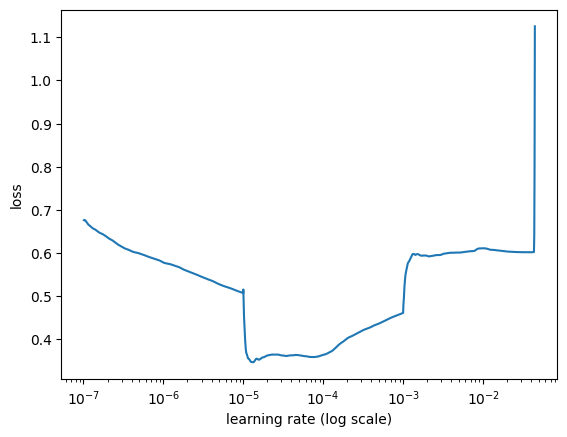

In [14]:
# Find the optimal learning rate for the model
learner.lr_find(show_plot=True, max_epochs=Config.EPOCHS)

#### 3.2.1.4 **Train Model**

In [15]:
# Train the model using the One-Cycle policy
LR = 1e-4
learner.fit_onecycle(LR, Config.EPOCHS)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
3270/3270 [==============================] - 9192s 3s/step - loss: 0.3616 - accuracy: 0.8601 - val_loss: 0.3435 - val_accuracy: 0.8656
Epoch 2/4
3270/3270 [==============================] - 9333s 3s/step - loss: 0.3272 - accuracy: 0.8729 - val_loss: 0.3483 - val_accuracy: 0.8707
Epoch 3/4
3270/3270 [==============================] - 9219s 3s/step - loss: 0.3967 - accuracy: 0.8343 - val_loss: 0.6084 - val_accuracy: 0.7203
Epoch 4/4
3270/3270 [==============================] - 9209s 3s/step - loss: 0.2940 - accuracy: 0.8889 - val_loss: 0.3936 - val_accuracy: 0.8493


## **4. Model Evaluation**

In [16]:
# Validate the model and display results
results = learner.validate(class_names=t.get_classes(), print_report=True)

154/154 [==============================] - 276s 2s/step
                precision    recall  f1-score   support

HEALTHY LIVING       0.80      0.62      0.70      1375
      WELLNESS       0.86      0.94      0.90      3530

      accuracy                           0.85      4905
     macro avg       0.83      0.78      0.80      4905
  weighted avg       0.85      0.85      0.84      4905



### **4.1 Model Evaluation Summary**

The evaluation metrics of the deep learning model indicate strong overall performance, with an **accuracy of 86%** in the first test and **85%** in the second. The **F1-score** is consistently high across both classes, demonstrating a good balance between precision and recall.

#### **4.1.1 Class-Specific Performance**
- The **Healthy Living** category achieved an **F1-score of 0.71**, with **precision at 0.79** and **recall at 0.64**. This suggests that the model tends to be more precise but struggles with recall, meaning some instances of this class might be misclassified.
- The **Wellness** category performed better, with an **F1-score of 0.90**, **precision at 0.87**, and **recall at 0.93**. The high recall indicates that the model effectively identifies this category, minimizing false negatives.

#### **4.1.2 Comparison with Prof. Cris Vargo's Model**
In comparison with the results from **Prof. Dr. Chris Vargo's model**, it appears that:
- Our model achieves similar **macro average scores (around 0.80-0.86)**, suggesting comparable generalization across categories.
- The **weighted average F1-score (0.85-0.86)** indicates that our model maintains stable performance considering the class imbalances.
- The key difference lies in the **recall for Healthy Living (0.64 vs. higher values in Cris Vargo’s model)**, which suggests room for improvement in correctly capturing this category.

#### **4.1.3 Final Thoughts**
While the current model demonstrates strong predictive ability, potential improvements could focus on **enhancing recall for the Healthy Living category**, possibly through **data augmentation, class balancing techniques, or adjusting decision thresholds**. Fine-tuning the model with additional hyperparameter optimization may also further align its performance with Prof. Cris Vargo’s results.


## **5. Predictors and Now Data Deployment**

In [17]:
# Create a predictor using the trained model and preprocessor
predictor = ktrain.get_predictor(learner.model, preproc=t)

# Define sample text inputs for classification
HEALTHY_LIVING = "Eating a balanced diet rich in fruits and vegetables"
WELLNESS       = "Regardless of your housing situation, there's always some form of physical activity you can do at home."

# Predict the category for the 'HEALTHY_LIVING' text
pred_HL = predictor.predict(HEALTHY_LIVING)
print(f"HEALTHY LIVING RESULT:    {pred_HL}")

# Predict the category for the 'WELLNESS' text
pred_W = predictor.predict(WELLNESS)
print(f"WELLNESS SENTENCE RESULT: {pred_W}")


HEALTHY LIVING RESULT:    HEALTHY LIVING
WELLNESS SENTENCE RESULT: HEALTHY LIVING


In [18]:
# Predicting the probability distribution for the HEALTHY_LIVING category
pred_HL_prob = predictor.predict_proba(HEALTHY_LIVING)
print(f"HEALTHY LIVING: {pred_HL_prob}")

# Predicting the probability distribution for the WELLNESS category
pred_W_prob = predictor.predict_proba(WELLNESS)
print(f"WELLNESS: {pred_W_prob}")


HEALTHY LIVING: [0.9949136  0.00508641]
WELLNESS: [0.90489846 0.0951015 ]


## **✅ Additional Information**



In [19]:
# End time
end_time = time.time()

# Calculate total execution time
total_time = end_time - start_time

# Convert total execution time to hours, minutes, and seconds
hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
seconds = int(total_time % 60)

# Print total execution time
print(f"Total execution time: {hours}h {minutes}m {seconds}s")

Total execution time: 19h 45m 33s


In [23]:
# Print the GPU information
!nvidia-smi

Tue Mar 25 08:50:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.03             Driver Version: 572.60         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 40%   36C    P8            N/A  /   75W |     747MiB /   4096MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----